Реализуйте класс MLP, представляющий многослойный перцептрон. Релизуйте возможность сохранить веса в файлы и загрузить их обратно. Убедитесь в том, чтоб перцептрон обучается.

Реализуйте классы

ActivationF, TanhF(ActivationF)

Unit

Layer

MLP

Детали реализации остаются за вами, но ниже приведены примеры -- заготовки, которые подошли мне, когда я сочинял тестовое решение.

Нельзя использовать математические и ML библиотеки кроме стандартных math и random. Использование матриц нежелательно -- идея в том, чтобы понять, что происходит с каждым весом в сети.



## Критерии 
(максимум можно получить 12 баллов):

про forward
* **(4 балла)** верно реализованы forward pass, сохранение модели в файл и восстановление модели из файла +
* **(1 балл)** верно реализован класс про функцию *Tanh* +

про backward (можно получить либо 1 либо 3 балла)
* **(1 балл)** как-то организован backward pass, но допущены значительные ошибки: лосс принципиально не падает, веса не обновляются или что-то такое.
* **(3 балла)** верно реализован backward pass, модель учится +

про вокруг
* **(2 балла)** при верном backward pass +
  * добавлена возможность использовать разные функции активации на разных слоях +
  * **И** софтмакс тоже вынесен в аналогичный активациям класс +
* **(2 балла)** при верном backward pass добавлена L-1 или L-2 регуляризация или дропаут +

In [1]:
import abc
import math
import random

class ActivationF(abc.ABC):

    def calc(self, x):
        pass

    def derive(self, x):
        pass

    @staticmethod
    def from_name(name="tanh"):
        if name == "tanh":
            return TanhF()
        if name == "sigmoid":
            return SigmF()
        if name == "softmax":
            return Softmax()

In [2]:
class SigmF(ActivationF):
    
    def calc(self, x):
        return 1 / (1 + math.exp(-x))#math.sigmoid(x)
    
    def derive(self, x):
        return (1 - self.calc(x)) * self.calc(x) 
    
class TanhF(ActivationF):
    
    def calc(self, x):
        return math.tanh(x)
    
    def derive(self, x):
        return 1 - math.tanh(x)**2
    
class Softmax(ActivationF):
    
    def calc(self, some_data):
        es_x = [math.e ** x for x in some_data]
        return [e_x / sum(es_x) for e_x in es_x]
    
    def derive(self, some_data):
        return [self.calc(x) * (1 - self.calc(x)) for x in some_data]

### Unit
класс `Unit` будет представлять нейрон в нейронной сети.  
словесно работает нейрон так: 
1. нейрону на вход подаётся набор чисел, 
2. он считает их взвешенную сумму, 
3. применяет к ней функцию активации.

обычно нейрон также умеет, зная, как он вложился в ошибку, обновить свои веса. это -- работа метода backward.

In [3]:
import numpy as np

class Unit:
    def __init__(self,
                 input_size,
                 prev_layer: "Layer" = None,
                 activation='sigmoid',
                 learning_rate=0.01, 
                 lambda_L2=0.01):
        self.activation = ActivationF.from_name(activation)
        self.weights = [random.uniform(-1, 1) for weight_n in range(input_size)]
        self.b = random.uniform(-1, 1)
        self.prev_layer = prev_layer
        self.learning_rate = learning_rate
        self.lambda_L2 = lambda_L2

    def forward(self, X):
        self.X = X
        self.Z = sum([i*j for (i, j) in zip(self.weights, self.X)]) + self.b
        self.A = self.activation.calc(self.Z)
        return self.A

    def backward(self, dX, learning_rate=0.01):
        dZ = self.activation.derive(self.Z) * dX
        dW = [dZ * i + self.lambda_L2 * j for (i, j) in zip(self.X, self.weights)]
        db = dZ
        dX = sum([i*dZ for i in self.weights])
        self.weights = [i - self.learning_rate * j for (i, j) in zip(self.weights, dW)]
        self.b = self.b - self.learning_rate * db
        return dX
        # your code here

### Layer
Должен иметь возможность создать очередной слой перцептрона.

In [4]:
class Layer:
    def __init__(self,
                 input_size,
                 size, 
                 prev_layer = None,
                 activation='sigmoid',
                 learning_rate=0.01, 
                 lambda_L2=0.01):
        self.activation = activation
        self.units = [Unit(input_size,
                           prev_layer=prev_layer,
                           activation=activation,
                           learning_rate=0.01,
                           lambda_L2=0.01)
                      for unit_n in range(size)]
    
    def forward(self, X):
        return [unit.forward(X) for unit in self.units]

    def backward(self, dX):
        return [unit.backward(dx) for (unit, dx) in zip(self.units, dX)]

### MLP
MLP должен 
* иметь произвольное кол-во слоёв произвольных размерностей
* обучатьтся
* уметь сохранять/загружать веса

In [5]:
import pickle

class MLP:
    def __init__(self,
                 input_size, 
                 output_size,
                 sizes, 
                 activations, 
                 learning_rate=0.01, 
                 lambda_L2=0.01):
        self.activations = activations
        
        layers_sizes = [input_size] + sizes + [output_size]
        self.layers = []
        self.out_actF = ActivationF.from_name("softmax")
        prev_added_layer = None
        for layer_in_size, layer_out_size, act in zip(layers_sizes[:-1], layers_sizes[1:], activations):
            self.layers.append(Layer(layer_in_size,
                                     layer_out_size,
                                     prev_layer=prev_added_layer,
                                     activation=act,
                                     learning_rate=learning_rate,
                                     lambda_L2=lambda_L2))
            prev_added_layer = self.layers[-1]
    
    def train_single_entry(self, features, target_mhe):
        for unit in self.layers[0].units:
            unit.features = features

        for layer in self.layers:
            curr_layer_output = layer.forward(features)
        last_layer_output = curr_layer_output

        pred = self.out_actF.calc(last_layer_output)
        loss = - sum(class_target * math.log(class_pred)
                     for class_target, class_pred in zip(target_mhe, pred))

        dLoss_dLastLayerOutput = [class_pred - class_target
                                  for class_target, class_pred in zip(target_mhe, pred)]    
        
        for layer in reversed(self.layers):
             dLoss_dLastLayerOutput = layer.backward(dLoss_dLastLayerOutput)
        return pred
        
    def predict(self, features):
        for layer in self.layers:
            curr_layer_output = layer.forward(features)
        return self.out_actF.calc(curr_layer_output)
    
    def to_file(self, path):
        with open(path, "wb") as f:
            pickle.dump(self, f)
        
    @staticmethod
    def from_file(path):
        with open(path, "rb") as f:
            res = pickle.load(f)
        return res

In [6]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df = pd.read_csv('housepricedata.csv')
df.head()

,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,AboveMedianPrice
0,8450,7,5,856,2,1,3,8,0,548,1
1,9600,6,8,1262,2,0,3,6,1,460,1
2,11250,7,5,920,2,1,3,6,1,608,1
3,9550,7,5,756,1,0,3,7,1,642,0
4,14260,8,5,1145,2,1,4,9,1,836,1


In [7]:
dataset = df.values
X = dataset[:,0:10]
Y = dataset[:,10]
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)


(1022, 10) (219, 10) (219, 10) (1022,) (219,) (219,)


In [8]:
Y_train
y_train_buf = []
for i in Y_train:
    if i == 1:
        y_train_buf.append([0, 1])
    else:
        y_train_buf.append([1, 0])

In [9]:
losses = []
accuracy = []
epoch = 100

mlp = MLP(10, 2, [10, 10], activations=['sigmoid', 'sigmoid', 'sigmoid'], learning_rate=0.01, lambda_L2=0.01)

for ep in range(epoch):
    print("Epoch: ", ep, "from", epoch, end="\r")
    loss = 0
    acc = 0
    for ind in range(X_train.shape[0]):
        pred = mlp.train_single_entry(X_train[ind, :], y_train_buf[ind])
        loss += - sum(class_target * math.log(class_pred)
                     for class_target, class_pred in zip(y_train_buf[ind], pred))
        acc += 1 if sum([1 for i, j in zip(y_train_buf[ind], np.round(pred)) if i == j]) == len(y_train_buf[ind]) else 0
    accuracy.append(acc/X_train.shape[0])
    losses.append(loss / X_train.shape[0])

Text(0, 0.5, 'Loss function')

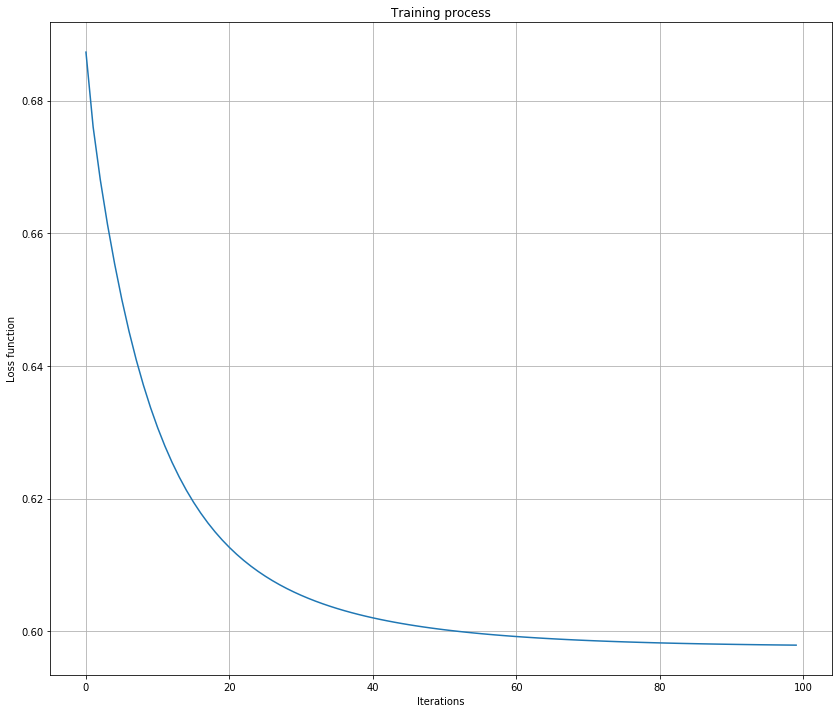

In [10]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function')

Text(0, 0.5, 'Accuracy function')

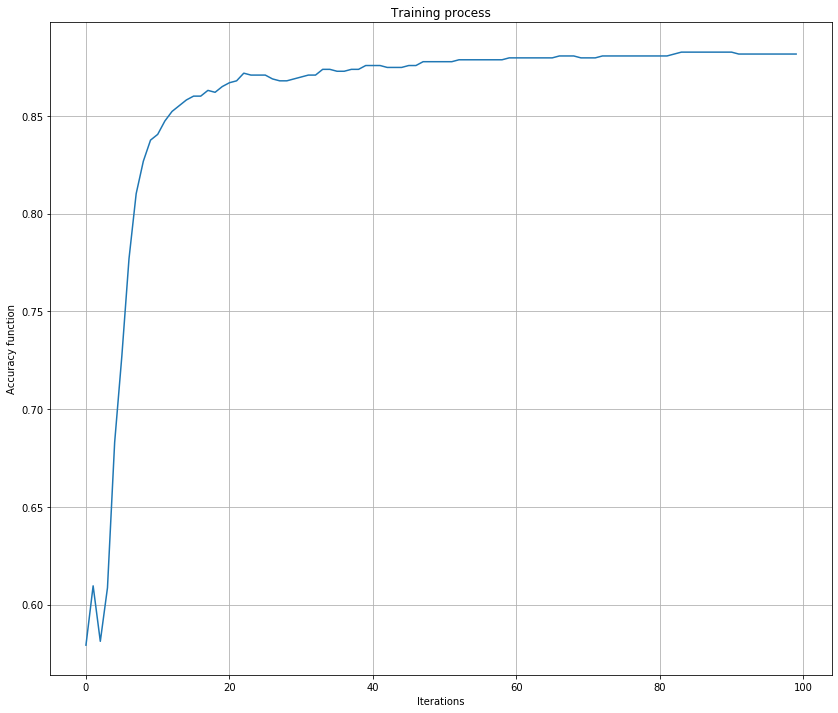

In [11]:
plt.figure(figsize=(14, 12))
plt.plot(accuracy)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Accuracy function')

## Save - load test

In [12]:
mlp.to_file("pickle_MLP.dat")

In [13]:
load_mlp = MLP.from_file("pickle_MLP.dat")

In [14]:
load_mlp.predict(X_train[6, :])

[0.540351143988658, 0.459648856011342]